In [9]:
import os
import time
import glob
import re
from functools import reduce
import numpy as np
import uproot
import uproot_methods
import awkward
import pandas as pd
from klepto.archives import dir_archive


import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib.pyplot as plt



In [49]:
#define processor

class WHhadProcessor(processor.ProcessorABC):
    def __init__(self):
        
        #define bins
        dataset_axis         = hist.Cat("dataset", "Primary dataset")
        pt_axis              = hist.Bin("pt", r"$p_{T}$ (GeV)", 500, 0, 2000)
        mass_axis            = hist.Bin("mass", r"$mass$ (GeV)", 100, 0, 2500)
        eta_axis             = hist.Bin("eta", r"$\eta$", 80, -4, 4)
        phi_axis             = hist.Bin("phi", r"$\Delta \phi$", 80, 0, 8)
        r_axis               = hist.Bin("r", r"$\Delta R$", 80, 0, 4)
        multiplicity_axis    = hist.Bin("multiplicity", r"N", 30, -0.5, 29.5)
        
        
        #define dictionary for plots
        self._accumulator = processor.dict_accumulator({
            "max_mt_b_met" :                hist.Hist("Counts", dataset_axis, mass_axis),
            "min_mt_b_met_1b" :             hist.Hist("Counts", dataset_axis, mass_axis),
            "min_mt_b_met_2b" :             hist.Hist("Counts", dataset_axis, mass_axis),
            "min_mt_b_met" :                hist.Hist("Counts", dataset_axis, mass_axis),
            "min_dphi_met_j" :              hist.Hist("Counts", dataset_axis, phi_axis),
            "min_dphi_met_wmch" :           hist.Hist("Counts", dataset_axis, phi_axis),
            "min_dphi_met_wmdh" :           hist.Hist("Counts", dataset_axis, phi_axis),
            })

    
    @property
    def accumulator(self):
        return self._accumulator

    
    def process(self, df):
        
        output = self.accumulator.identity()
        
        dataset = df['dataset']

        #MET
        metphi = df["MET_phi"]
        metpt = df["MET_pt"]
        
        #leptons
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content, 
            cutbased=df['Electron_cutBased'].content
        )
        
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content, 
            eta=df['Muon_eta'].content, 
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            pdgid=df['Muon_pdgId'].content,
            mini_iso=df['Muon_miniPFRelIso_all'].content, 
            looseid =df['Muon_looseId'].content
        )
        
        taus = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        
        isotracks = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            mini_iso=df['IsoTrack_miniPFRelIso_all'], 
        )
        
        #jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content, 
            eta=df['Jet_eta'].content, 
            phi=df['Jet_phi'].content,
            btag=df['Jet_btagDeepB'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['Jet_mass'].content,
        )
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content, 
            btag=df['FatJet_btagDeepB'].content, 
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            fromW_MD = df['FatJet_deepTagMD_WvsQCD'].content, 
            fromW_MC = df['FatJet_deepTag_WvsQCD'].content,
            fatjetid=df['FatJet_jetId'].content,
        )
        
        #ak4's
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0))
        goodjets = jets[goodjcut]
        jetpt_sorted = goodjets.pt.argsort(ascending=False)
        leadjet = goodjets[jetpt_sorted==0]
        subleadjet = goodjets[jetpt_sorted==1]
        leadjets = goodjets[jetpt_sorted <= 1]
      
        bjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag>0.4184))
        bjets = jets[bjcut]
        bjetpt = bjets.pt
        bjetpt_sorted = bjetpt.argsort(ascending=False)
        leadbjet = bjets[bjetpt_sorted==0]
        subleadbjet = bjets[bjetpt_sorted==1]
        leadbjets = bjets[bjetpt_sorted <= 1]
            
        nonbjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag<0.4184))
        nbjets = jets[nonbjcut]
        nbjetpt_sorted = nbjets.pt.argsort(ascending=False)
        leadnbjet = nbjets[nbjetpt_sorted==0]
        subleadnbjet = nbjets[nbjetpt_sorted==1]
        leadnbjets = nbjets[nbjetpt_sorted <= 1]

        
        #ak8's
        goodfjcut = ((fatjets.pt > 200) & (fatjets.fatjetid>0))
        goodfatjets = fatjets[goodfjcut]
        
        htagcut = ((fatjets.pt > 200) & (fatjets.fatjetid>0) & (fatjets.fromH > 0.8365))
        htagged = fatjets[htagcut]
        htagpt_sorted = htagged.pt.argsort(ascending=False)
        leadhtag = htagged[htagpt_sorted==0]
        subleadhtag = htagged[htagpt_sorted==1]
        leadhtags = htagged[htagpt_sorted <= 1]
        
        wtagcut_mc = ((fatjets.pt > 200) & (fatjets.fatjetid>0) & (fatjets.fromW_MC > 0.9) & (fatjets.fromH < 0.8365))
        wtagcut_md = ((fatjets.pt > 200) & (fatjets.fatjetid>0) & (fatjets.fromW_MD > 0.9) & (fatjets.fromH < 0.8365))
        wtagged_mc = fatjets[wtagcut_mc]
        wtagged_md = fatjets[wtagcut_md]
        wtagmcpt_sorted = wtagged_mc.pt.argsort(ascending=False)
        leadwmctag = wtagged_mc[wtagmcpt_sorted==0]
        subleadwmctag = wtagged_mc[wtagmcpt_sorted==1]
        leadwmctags = wtagged_mc[wtagmcpt_sorted <= 1]
        wtagmdpt_sorted = wtagged_md.pt.argsort(ascending=False)
        leadwmdtag = wtagged_md[wtagmdpt_sorted==0]
        subleadwmdtag = wtagged_md[wtagmdpt_sorted==1]
        leadwmdtags = wtagged_md[wtagmdpt_sorted <= 1]
 
        WmcH = leadwmctag.cross(leadhtag)
        WmcHpt_sorted = WmcH.pt.argsort(ascending=False)
        leadWmcleadH = WmcH[WmcHpt_sorted <=1]

        WmdH = leadwmdtag.cross(leadhtag)
        WmdHpt_sorted = WmdH.pt.argsort(ascending=False)
        leadWmdleadH = WmdH[WmdHpt_sorted <=1]

        
        
        #leptons
        
        veto_e_cut = (electrons.pt>5) & (abs(electrons.eta) < 2.4) & (electrons.cutbased  == 1) & (electrons.mini_iso < 0.2)
        veto_e = electrons[veto_e_cut]
        
        veto_m_cut = (muons.pt > 5) & (abs(muons.eta) < 2.4) & (muons.looseid) & (muons.mini_iso < 0.2)
        veto_m = muons[veto_m_cut]
        
        veto_t_cut = (taus.pt > 20) & (abs(taus.eta) < 2.4) & (taus.decaymode) & (taus.newid == 8)
        veto_t = taus[veto_t_cut]
        
        veto_it_cut = (isotracks.pt > 10) & (abs(isotracks.eta) < 2.4) & ((isotracks.mini_iso < (0.1*isotracks.pt)) | (isotracks.mini_iso < 6))
        veto_it = isotracks[veto_it_cut]
        
        #MT
               
        
        dphi_leadbs_met = abs((leadbjets.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        mt_b_met = np.sqrt(2*leadbjets.pt*metpt*(1-np.cos(dphi_leadbs_met)))

        print(mt_b_met)
        
        sorted_min_mt_b_met = mt_b_met.argsort(ascending=True)
        print(sorted_min_mt_b_met)
        sorted_max_mt_b_met = mt_b_met.argsort(ascending=False)
        min_mt_b_met = mt_b_met[sorted_min_mt_b_met == 0]
        print("min", min_mt_b_met)
        max_mt_b_met = mt_b_met[sorted_max_mt_b_met == 0]
        print("max", max_mt_b_met)

        
        #DPHI
        dphi_met_leadjs = abs((leadjets.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        sorted_dphi_met_leadjs = dphi_met_leadjs.argsort(ascending=True)
        min_dphi_met_leadjs = dphi_met_leadjs[sorted_dphi_met_leadjs==0]
        abs_min_dphi_met_leadjs = abs(min_dphi_met_leadjs)
        
        dphi_met_wmch = abs((leadWmcleadH.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        sorted_dphi_met_wmch = dphi_met_wmch.argsort(ascending=True)
        min_dphi_met_wmch = dphi_met_wmch[sorted_dphi_met_wmch==0]
        abs_min_dphi_met_wmch = abs(min_dphi_met_wmch)
        
        dphi_met_wmdh = abs((leadWmdleadH.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        sorted_dphi_met_wmdh = dphi_met_wmdh.argsort(ascending=True)
        min_dphi_met_wmdh = dphi_met_wmdh[sorted_dphi_met_wmdh==0]
        abs_min_dphi_met_wmdh = abs(min_dphi_met_wmdh)
        
        #PRESELECTION
        ht = goodjets.pt.sum()
        
        met_ps = (metpt>250)
        njet_ps = (df['GoodJet_pt'].counts >= 2)
        bjet_ps = (df['BJet_pt'].counts >= 1)
        ht_ps = (ht > 300)
        
        presel = met_ps & njet_ps & bjet_ps  & ht_ps
        sel1 = met_ps & njet_ps & ht_ps
        onebsel = met_ps & njet_ps & ht_ps & (htagged.counts > 0) & (df['BJet_pt'].counts == 1)
        twobsel = met_ps & njet_ps & ht_ps & (htagged.counts > 0) & (df['BJet_pt'].counts == 2)
        
        e_sel = (veto_e.counts == 0)
        m_sel = (veto_m.counts == 0)
        it_sel = (veto_it.counts == 0)
        t_sel = (veto_t.counts == 0)
        l_sel = e_sel & m_sel & it_sel & t_sel
        
        sel = sel1 & l_sel
        
        
        #DEFINE VARIABLES 
    
    
        wght = df['weight'][0] * 137* 1000

        #FILL OUTPUTS
        output['max_mt_b_met'].fill(dataset=dataset, mass=max_mt_b_met[sel].flatten(), weight=wght)
        output['min_mt_b_met'].fill(dataset=dataset, mass=min_mt_b_met[sel].flatten(), weight=wght)
        output['min_mt_b_met_1b'].fill(dataset=dataset, mass=min_mt_b_met[onebsel].flatten(), weight=wght)
        output['min_mt_b_met_2b'].fill(dataset=dataset, mass=min_mt_b_met[twobsel].flatten(), weight=wght)
        output['min_dphi_met_j'].fill(dataset=dataset, phi=abs_min_dphi_met_leadjs[sel].flatten(), weight=wght)
        output['min_dphi_met_wmch'].fill(dataset=dataset, phi=abs_min_dphi_met_wmch[sel].flatten(), weight=wght)
        output['min_dphi_met_wmdh'].fill(dataset=dataset, phi=abs_min_dphi_met_wmdh[sel].flatten(), weight=wght)

        
        return output

    
    def postprocess(self, accumulator):
        return accumulator
        

In [50]:
fileset_sig = {'mC750_l1': ['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/WH_had_750_1__nanoAOD/merged/WH_had_750_1__nanoAOD_1.root']}
fileset_back = {'W+Jets': ['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root'
                          ],
                'QCD': ['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv96/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv96/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root'
                     ],
            'TTJets':['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root'
                   ],
            "ZNuNu":['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-600To800_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-600To800_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-800To1200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-800To1200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root'
                     ]
                }


output_sig = processor.run_uproot_job(fileset_sig,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_back = processor.run_uproot_job(fileset_back,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )



[[416.0242] [744.61383] [] ... [580.8889 388.67062] [916.20306 521.55975] [495.392]]
[[0] [0] [] ... [1 0] [1 0] [0]]
min [[416.0242] [744.61383] [] ... [388.67062] [521.55975] [495.392]]
max [[416.0242] [744.61383] [] ... [580.8889] [916.20306] [495.392]]



[[] [] [] ... [] [] []]
[[] [] [] ... [] [] []]
min [[] [] [] ... [] [] []]
max [[] [] [] ... [] [] []]
[[] [] [] ... [] [] []]
[[] [] [] ... [] [] []]
min [[] [] [] ... [] [] []]
max [[] [] [] ... [] [] []]
[[] [] [] ... [] [916.66614 40.79561] []]
[[] [] [] ... [] [1 0] []]
min [[] [] [] ... [] [40.79561] []]
max [[] [] [] ... [] [916.66614] []]
[[] [] [] ... [851.58795] [] []]
[[] [] [] ... [0] [] []]
min [[] [] [] ... [851.58795] [] []]
max [[] [] [] ... [851.58795] [] []]
[[363.2274] [759.9083 1.2162238] [29.427986 32.967834] ... [156.5258 88.71087] [169.38727] [15.792089 195.11356]]
[[0] [1 0] [0 1] ... [1 0] [0] [0 1]]
min [[363.2274] [1.2162238] [29.427986] ... [88.71087] [169.38727] [15.792089]]
max [[363.2274] [759.9083] [32.967834] ... [156.5258] [169.38727] [195.11356]]
[[] [] [] ... [297.07538] [] []]
[[] [] [] ... [0] [] []]
min [[] [] [] ... [297.07538] [] []]
max [[] [] [] ... [297.07538] [] []]
[[] [55.252888 86.47331] [1705.0858] ... [20.357735 1029.2792] [] [137.5161

In [51]:
histograms = ["max_mt_b_met","min_mt_b_met", "min_mt_b_met_1b", "min_mt_b_met_2b",
              "min_dphi_met_j","min_dphi_met_wmch","min_dphi_met_wmdh"]

outdir = "/home/users/mbryson/public_html/dump/WH/min"

In [52]:
lineopts = {
    'color': 'r',
}

data_err_opts = {
    'linestyle': 'none',
    'marker': '_',
    'markersize': 10.,
    'color': 'r',
    'elinewidth': 1,
}

lineopts2 = {
    'color': [('#1467cc'), ('#51d673') ,('#f7d969'), ('#af84f0')],
}
fillopts1 = {
    'edgecolor': (0,0,0,0.3),
    'facecolor': [('#1467cc'), ('#51d673') ,('#f7d969'), ('#af84f0')],
}


def savefig(signal, background, outdir, name):
    ax = hist.plot1d(background, overlay="dataset", density=False, stack=True, 
                fill_opts = fillopts1, overflow = 'over')
    hist.plot1d(signal, overlay="dataset", density=False, stack=False, 
                error_opts=data_err_opts, overflow = 'over') 
    ax.set_yscale('log')
    ax.set_ylim(0.001,1000000)
    ax.figure.savefig(os.path.join(outdir, "{}_log.png".format(name)))
    ax.clear()


    
def savefigshape(signal, background, outdir, name):
    ax = hist.plot1d(background, overlay="dataset", density=True, stack=False, 
                line_opts = lineopts2, overflow = 'over')
    hist.plot1d(signal, overlay="dataset", density=True, stack=False, 
                error_opts=data_err_opts, overflow = 'over') 
    ax.set_yscale('log')
    ax.set_ylim(0.00001,10)
    ax.figure.savefig(os.path.join(outdir, "{}_shape_log.png".format(name)))
    ax.clear()

max_mt_b_met
min_mt_b_met
min_mt_b_met_1b
min_mt_b_met_2b
min_dphi_met_j
min_dphi_met_wmch
min_dphi_met_wmdh


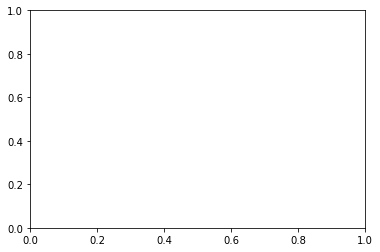

In [53]:
for name in histograms:
    print (name)
    histo_sig = output_sig[name]
    histo_back = output_back[name]
    #rebinning
    if name == "max_mt_b_met":
        new_mmbm_bins = hist.Bin('mass', r' max(mt(b,MET))', 100, 0, 2500)
        histo_sig = histo_sig.rebin('mass', new_mmbm_bins)
        histo_back = histo_back.rebin('mass', new_mmbm_bins)  
    if name == "min_mt_b_met":
        new_mmbm_bins = hist.Bin('mass', r' min(mt(b,MET))', 100, 0, 2500)
        histo_sig = histo_sig.rebin('mass', new_mmbm_bins)
        histo_back = histo_back.rebin('mass', new_mmbm_bins)  
    if name == "min_mt_b_met_1b":
        new_mmbm1_bins = hist.Bin('mass', r' min(mt(b,MET)) (bjets = 1) ', 100, 0, 2500)
        histo_sig = histo_sig.rebin('mass', new_mmbm1_bins)
        histo_back = histo_back.rebin('mass', new_mmbm1_bins)  
    if name == "min_mt_b_met_2b":
        new_mmbm2_bins = hist.Bin('mass', r' min(mt(b,MET)) (bjets = 2) ', 100, 0, 2500)
        histo_sig = histo_sig.rebin('mass', new_mmbm2_bins)
        histo_back = histo_back.rebin('mass', new_mmbm2_bins)  
    if name == "min_dphi_met_j":
        new_mdmj_bins = hist.Bin('phi', r' $|\Delta \Phi$(MET, lead jet)| ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_mdmj_bins)
        histo_back = histo_back.rebin('phi', new_mdmj_bins)
    if name == "min_dphi_met_wmch":
        new_mdmw_bins = hist.Bin('phi', r' $|\Delta \Phi$(MET, W/H)| (Mass Correlated W tag) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_mdmw_bins)
        histo_back = histo_back.rebin('phi', new_mdmw_bins)
    if name == "min_dphi_met_wmdh":
        new_mdmw_bins = hist.Bin('phi', r' $|\Delta \Phi$(MET, W/H)| (Mass Decorrelated W tag)', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_mdmw_bins)
        histo_back = histo_back.rebin('phi', new_mdmw_bins)
    savefig(histo_sig, histo_back,outdir, name)
    savefigshape(histo_sig, histo_back,outdir, name)